In [1]:
import pandas as pd
import numpy as np
import pyedflib ## 读取BDF数据 
import matplotlib.pyplot as plt

# pytorch相关
import torch
import torchvision
import torch.nn as nn

import torch.nn.functional as F
import torch.utils.data as data
import torch.utils.data.dataset as Dataset
import torch.utils.data.dataloader as DataLoader

# 信号处理
from scipy import signal
from scipy.fftpack import fft,ifft,fftshift
from scipy.signal import welch

from utils2 import *
from model import *

from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

import pywt

In [2]:
eeg_trial_list, eye_track_trial_list, arousal_label_map, valence_label_map, emotion_label_map = get_one_data_pd(1)

In [3]:
arousal_label_map

array([0, 2, 1, 1, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 0, 0, 1, 0, 1])

In [4]:
re_eeg_data, re_eye_track_data, trial_arousal_label, trial_valence_label = get_one_data_re(1)

In [5]:
def train_model(model, batch_size, n_epochs, verbose=True, model_save_path=None):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = [] 
    # to track the training correct count per epoch as the model trains
    train_correct_count = 0.0
    # to track the validation correct count per epoch as the model trains
    valid_correct_count = 0.0
    
    best_valid_acc = 0.0
    
    hist = pd.DataFrame(columns=['train_loss','train_acc','valid_loss','valid_acc'])
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, label) in enumerate(trainloader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            _, pred = torch.max(output, 1)
            loss = criterion(output, label.squeeze())
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            # record training correct number
            train_correct_count += ((pred==label.squeeze()).sum())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, label in testloader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            _, pred = torch.max(output, 1)
            loss = criterion(output, label.squeeze())
            
            # record validation loss
            valid_losses.append(loss.item())
            # record validation correct number
            valid_correct_count += ((pred==label.squeeze()).sum())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        
        train_acc = train_correct_count/len(trainloader.dataset)
        valid_acc = valid_correct_count/len(testloader.dataset)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' + f'train_acc: {train_acc:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} ' + f'valid_acc: {valid_acc:.5f} ')
        
        hist.loc[epoch-1, :] = [train_loss, train_acc.item(), valid_loss, valid_acc.item()]
        
        if verbose:
            print(print_msg)
        
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            if model_save_path is not None:
                torch.save(model.state_dict(), model_save_path)
        
        # clear lists and count to track next epoch
        train_losses = []
        valid_losses = []
        train_correct_count = 0.0
        valid_correct_count = 0.0
    
#     if model_save_path is not None:
#         torch.save(model.state_dict(), model_save_path)
        
    return  model, hist

In [6]:
def train_model2(model, batch_size, n_epochs, verbose=True, model_save_path=None):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    test_losses = []
    valid_losses = [] 
    # to track the training correct count per epoch as the model trains
    train_correct_count = 0.0
    # to track the validation correct count per epoch as the model trains
    test_correct_count = 0.0
    valid_correct_count = 0.0
    
    best_test_acc = 0.0
    
    hist = pd.DataFrame(columns=['train_loss','train_acc','valid_loss','valid_acc','test_loss','test_acc'])
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, label) in enumerate(trainloader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            _, pred = torch.max(output, 1)
            loss = criterion(output, label.squeeze())
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            # record training correct number
            train_correct_count += ((pred==label.squeeze()).sum())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, label in testloader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            _, pred = torch.max(output, 1)
            loss = criterion(output, label.squeeze())
            # record validation loss
            test_losses.append(loss.item())
            # record validation correct number
            test_correct_count += ((pred==label.squeeze()).sum())
        
        model.eval()  
        for data, label in validloader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            _, pred = torch.max(output, 1)
            loss = criterion(output, label.squeeze())
            # record validation loss
            valid_losses.append(loss.item())
            # record validation correct number
            valid_correct_count += ((pred==label.squeeze()).sum())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        test_loss = np.average(test_losses)
        
        train_acc = train_correct_count/len(trainloader.dataset)
        valid_acc = valid_correct_count/len(validloader.dataset)
        test_acc = test_correct_count/len(testloader.dataset)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' + f'train_acc: {train_acc:.5f} ' +
                     f'test_loss: {test_loss:.5f} ' + f'test_acc: {test_acc:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} ' + f'valid_acc: {valid_acc:.5f} ')
        
        hist.loc[epoch-1, :] = [train_loss, train_acc.item(), valid_loss, valid_acc.item(), test_loss, test_acc.item()]
        
        if verbose:
            print(print_msg)
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            if model_save_path is not None:
                torch.save(model.state_dict(), model_save_path)
        
        # clear lists and count to track next epoch
        train_losses = []
        valid_losses = []
        test_losses = []
        train_correct_count = 0.0
        valid_correct_count = 0.0
        test_correct_count = 0.0
    
#     if model_save_path is not None:
#         torch.save(model.state_dict(), model_save_path)
        
    return  model, hist

In [7]:
model = create_model("Simple_CNN", verbose=False)

In [8]:
train_x, train_y, test_x, test_y = split_train_test(re_eeg_data, trial_arousal_label, 0.7)

In [9]:
# train_x, train_y, test_x, test_y = balance_data_and_re(eeg_trial_list, arousal_label_map, window_len=256*10, overlap=0.5, split_rate=0.7)

In [10]:
train_data = subDataset(train_x, train_y)
test_data = subDataset(test_x, test_y)

In [11]:
train_data.Data.shape

(199, 32, 1, 2560)

In [12]:
# criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss(3)
criterion = FocalLossBaseCE(alpha=0.8, gamma=4)
# , weight_decay=0.009
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

In [13]:
Batch_size = 128
trainloader = DataLoader.DataLoader(train_data, batch_size = Batch_size, shuffle = True, num_workers = 0)
testloader = DataLoader.DataLoader(test_data, batch_size = Batch_size, shuffle = False, num_workers = 0)

In [14]:
new_model, hist = train_model(model, Batch_size, n_epochs=10000, verbose=True)

[    1/10000] train_loss: 0.61155 train_acc: 0.34673 valid_loss: 0.20961 valid_acc: 0.39024 
[    2/10000] train_loss: 0.45568 train_acc: 0.36683 valid_loss: 0.21847 valid_acc: 0.39024 
[    3/10000] train_loss: 0.32976 train_acc: 0.41206 valid_loss: 0.22164 valid_acc: 0.40244 
[    4/10000] train_loss: 0.31958 train_acc: 0.43216 valid_loss: 0.23090 valid_acc: 0.41463 
[    5/10000] train_loss: 0.24115 train_acc: 0.38191 valid_loss: 0.19104 valid_acc: 0.40244 
[    6/10000] train_loss: 0.20756 train_acc: 0.47236 valid_loss: 0.19461 valid_acc: 0.39024 
[    7/10000] train_loss: 0.17752 train_acc: 0.44724 valid_loss: 0.18977 valid_acc: 0.35366 
[    8/10000] train_loss: 0.15808 train_acc: 0.48744 valid_loss: 0.19527 valid_acc: 0.30488 
[    9/10000] train_loss: 0.15869 train_acc: 0.49246 valid_loss: 0.18660 valid_acc: 0.31707 
[   10/10000] train_loss: 0.14573 train_acc: 0.54774 valid_loss: 0.18043 valid_acc: 0.39024 
[   11/10000] train_loss: 0.13721 train_acc: 0.58291 valid_loss: 0.179

In [15]:
hist['train_error'] = 1-hist['train_acc']
hist['test_error'] = 1-hist['valid_acc']

<AxesSubplot:>

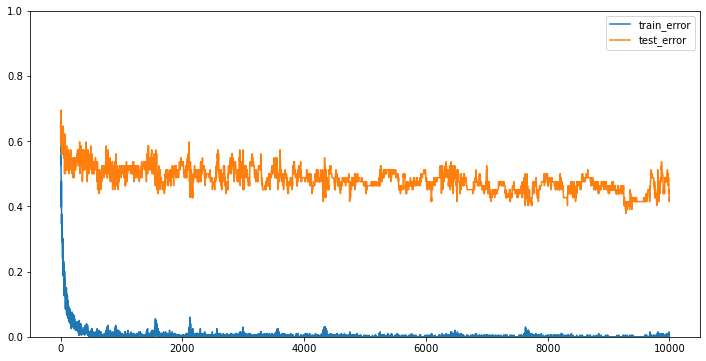

In [16]:
hist[['train_error','test_error']].plot(figsize = (12, 6), ylim=(0,1))

## 验证

In [7]:
re_eeg_data2, re_eye_track_data2, trial_arousal_label2, trial_valence_label2 = get_one_data_re(2)

In [8]:
re_eeg_data2.shape

(281, 2560, 32)

In [9]:
norm_re_eeg_data2 = []
for i in np.arange(len(re_eeg_data2)):
    norm_re_eeg_data2.append(my_norm_data(re_eeg_data2[i]))
re_eeg_data2 = np.asarray(norm_re_eeg_data2)

In [10]:
re_eeg_data2.shape

(281, 32, 2560)

In [11]:
valid_x = re_eeg_data2[:,:,np.newaxis,:]
valid_y = trial_arousal_label2.reshape(-1,1)

In [12]:
valid_x.shape

(281, 32, 1, 2560)

In [13]:
valid_data = subDataset(valid_x, valid_y)

In [17]:
train_data = subDataset(train_x, train_y)
test_data = subDataset(test_x, test_y)

In [18]:
model = create_model("Simple_CNN")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1          [-1, 64, 1, 2560]           2,112
       BatchNorm2d-2          [-1, 64, 1, 2560]             128
              ReLU-3          [-1, 64, 1, 2560]               0
            Conv1d-4           [-1, 1, 1, 2560]              65
       BatchNorm2d-5           [-1, 1, 1, 2560]               2
              ReLU-6           [-1, 1, 1, 2560]               0
            Linear-7                  [-1, 128]         327,808
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                    [-1, 3]             387
Total params: 330,502
Trainable params: 330,502
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.31
Forward/backward pass size (MB): 3.81
Params size (MB): 1.26
Estimated T

In [19]:
# criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss(3)
criterion = FocalLossBaseCE(alpha=0.8, gamma=4)
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4, weight_decay=0.009)

In [20]:
Batch_size = 128
trainloader = DataLoader.DataLoader(train_data, batch_size = Batch_size, shuffle = True, num_workers = 0)
testloader = DataLoader.DataLoader(test_data, batch_size = Batch_size, shuffle = False, num_workers = 0)
validloader = DataLoader.DataLoader(valid_data, batch_size = Batch_size, shuffle = False, num_workers = 0)

In [21]:
new_model, hist = train_model2(model, Batch_size, n_epochs=10000, verbose=True)

[    1/10000] train_loss: 0.75674 train_acc: 0.26633 test_loss: 1.32737 test_acc: 0.39024 valid_loss: 2.08255 valid_acc: 0.30605 
[    2/10000] train_loss: 0.49908 train_acc: 0.33166 test_loss: 0.22853 test_acc: 0.45122 valid_loss: 0.61328 valid_acc: 0.34875 
[    3/10000] train_loss: 0.32724 train_acc: 0.36683 test_loss: 0.33015 test_acc: 0.40244 valid_loss: 0.44689 valid_acc: 0.41993 
[    4/10000] train_loss: 0.28116 train_acc: 0.39196 test_loss: 0.25120 test_acc: 0.30488 valid_loss: 0.33465 valid_acc: 0.33452 
[    5/10000] train_loss: 0.28971 train_acc: 0.37186 test_loss: 0.26428 test_acc: 0.36585 valid_loss: 0.36715 valid_acc: 0.37367 
[    6/10000] train_loss: 0.28198 train_acc: 0.38693 test_loss: 0.19042 test_acc: 0.34146 valid_loss: 0.35435 valid_acc: 0.39502 
[    7/10000] train_loss: 0.26875 train_acc: 0.42211 test_loss: 0.18166 test_acc: 0.43902 valid_loss: 0.36180 valid_acc: 0.44840 
[    8/10000] train_loss: 0.22111 train_acc: 0.44724 test_loss: 0.17463 test_acc: 0.46341 

In [22]:
hist['train_error'] = 1-hist['train_acc']
hist['test_error'] = 1-hist['test_acc']
hist['valid_error'] = 1-hist['valid_acc']

<AxesSubplot:>

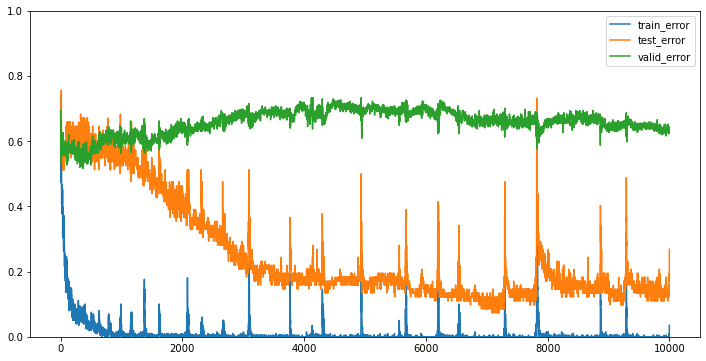

In [23]:
hist[['train_error','test_error','valid_error']].plot(figsize = (12, 6), ylim=(0,1))

In [2]:
eeg_trial_list, eye_track_trial_list, arousal_label_map, valence_label_map, emotion_label_map = get_one_data_pd(1)

In [3]:
re_eeg_data, re_eye_track_data, trial_arousal_label, trial_valence_label = get_one_data_re(1)

In [4]:
train_x, train_y, test_x, test_y = split_train_test(re_eeg_data, trial_arousal_label, 0.7)

In [5]:
train_data = subDataset(train_x, train_y)
test_data = subDataset(test_x, test_y)

In [6]:
re_eeg_data2, re_eye_track_data2, trial_arousal_label2, trial_valence_label2 = get_one_data_re(2)

In [7]:
norm_re_eeg_data2 = []
for i in np.arange(len(re_eeg_data2)):
    norm_re_eeg_data2.append(my_norm_data(re_eeg_data2[i]))
re_eeg_data2 = np.asarray(norm_re_eeg_data2)

In [8]:
valid_x = re_eeg_data2[:,:,np.newaxis,:]
valid_y = trial_arousal_label2.reshape(-1,1)

In [9]:
valid_data = subDataset(valid_x, valid_y)

In [36]:
Batch_size = 64
trainloader = DataLoader.DataLoader(train_data, batch_size = Batch_size, shuffle = True, num_workers = 0)
testloader = DataLoader.DataLoader(test_data, batch_size = Batch_size, shuffle = False, num_workers = 0)
validloader = DataLoader.DataLoader(valid_data, batch_size = Batch_size, shuffle = False, num_workers = 0)

In [37]:
model = create_model("CNNModel", verbose=False)

In [38]:
for p in model.parameters():
    p.requires_grad = True

In [39]:
loss_class = nn.CrossEntropyLoss()
loss_domain = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4, weight_decay=0.009)

In [40]:
def train_model3(model, batch_size, n_epochs, verbose=True, model_save_path=None):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    test_losses = []
    valid_losses = [] 
    # to track the training correct count per epoch as the model trains
    train_correct_count = 0.0
    # to track the validation correct count per epoch as the model trains
    test_correct_count = 0.0
    valid_correct_count = 0.0
    
    best_test_acc = 0.0
    
    hist = pd.DataFrame(columns=['train_loss','train_acc','valid_loss','valid_acc','test_loss','test_acc'])
    
    for epoch in range(1, n_epochs + 1):
        
        len_dataloader = min(len(trainloader), len(validloader))
        data_source_iter = iter(trainloader)
        data_target_iter = iter(validloader)
        
        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        
        i = 0
        while i < len_dataloader:
            
            p = float(i + epoch * len_dataloader) / n_epochs / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            
            # training model using source data
            data_source = data_source_iter.next()
            s_data, s_label = data_source

            model.zero_grad()
            batch_size = len(s_label)
            
            domain_label = torch.zeros(batch_size).long().cuda()
        
            class_output, domain_output = model(input_data=s_data, alpha=alpha)
            err_s_label = loss_class(class_output, s_label.squeeze())
            err_s_domain = loss_domain(domain_output, domain_label.squeeze())
            
            # training model using target data
            data_target = data_target_iter.next()
            t_data, _ = data_target
            
            batch_size = len(t_data)
            
            domain_label = torch.ones(batch_size).long().cuda()

            _, domain_output = model(input_data=t_data, alpha=alpha)
            err_t_domain = loss_domain(domain_output, domain_label.squeeze())
            err = err_t_domain + err_s_domain + err_s_label
            err.backward()
            optimizer.step()

            i += 1
            
#             print('epoch: %d, [iter: %d / all %d], err_s_label: %f, err_s_domain: %f, err_t_domain: %f' % (epoch, i, len_dataloader, err_s_label.cpu().data.numpy(),
#                  err_s_domain.cpu().data.numpy(), err_t_domain.cpu().data.numpy()))
        
            train_losses.append(err_s_label.item())
            _, pred = torch.max(class_output, 1)
            train_correct_count += ((pred==s_label.squeeze()).sum())
            
#         for batch, (data, label) in enumerate(trainloader, 1):
#             # clear the gradients of all optimized variables
#             optimizer.zero_grad()
#             # forward pass: compute predicted outputs by passing inputs to the model
#             output = model(data)
#             # calculate the loss
#             _, pred = torch.max(output, 1)
#             loss = criterion(output, label.squeeze())
#             # backward pass: compute gradient of the loss with respect to model parameters
#             loss.backward()
#             # perform a single optimization step (parameter update)
#             optimizer.step()
#             # record training loss
#             train_losses.append(loss.item())
#             # record training correct number
#             train_correct_count += ((pred==label.squeeze()).sum())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, label in testloader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output, _ = model(data,alpha=0)
            # calculate the loss
            _, pred = torch.max(output, 1)
            loss = loss_class(output, label.squeeze())
            # record validation loss
            test_losses.append(loss.item())
            # record validation correct number
            test_correct_count += ((pred==label.squeeze()).sum())
        
        model.eval()  
        for data, label in validloader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output, _ = model(data,alpha=0)
            # calculate the loss
            _, pred = torch.max(output, 1)
            loss = loss_class(output, label.squeeze())
            # record validation loss
            valid_losses.append(loss.item())
            # record validation correct number
            valid_correct_count += ((pred==label.squeeze()).sum())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        test_loss = np.average(test_losses)
        
        train_acc = train_correct_count/len(trainloader.dataset)
        valid_acc = valid_correct_count/len(validloader.dataset)
        test_acc = test_correct_count/len(testloader.dataset)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' + f'train_acc: {train_acc:.5f} ' +
                     f'test_loss: {test_loss:.5f} ' + f'test_acc: {test_acc:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} ' + f'valid_acc: {valid_acc:.5f} ')
        
        hist.loc[epoch-1, :] = [train_loss, train_acc.item(), valid_loss, valid_acc.item(), test_loss, test_acc.item()]
        
        if verbose:
            print(print_msg)
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            if model_save_path is not None:
                torch.save(model.state_dict(), model_save_path)
        
        # clear lists and count to track next epoch
        train_losses = []
        valid_losses = []
        test_losses = []
        train_correct_count = 0.0
        valid_correct_count = 0.0
        test_correct_count = 0.0
    
#     if model_save_path is not None:
#         torch.save(model.state_dict(), model_save_path)
        
    return  model, hist

In [41]:
model, hist = train_model3(model, Batch_size, n_epochs=10000, verbose=True)

[    1/10000] train_loss: 1.91926 train_acc: 0.21106 test_loss: 1.33682 test_acc: 0.17073 valid_loss: 2.05210 valid_acc: 0.20285 
[    2/10000] train_loss: 1.65137 train_acc: 0.22111 test_loss: 1.27687 test_acc: 0.18293 valid_loss: 1.71126 valid_acc: 0.22064 
[    3/10000] train_loss: 1.81327 train_acc: 0.21608 test_loss: 1.17406 test_acc: 0.20732 valid_loss: 1.59370 valid_acc: 0.20996 
[    4/10000] train_loss: 1.67398 train_acc: 0.21608 test_loss: 1.14146 test_acc: 0.23171 valid_loss: 1.57158 valid_acc: 0.18505 
[    5/10000] train_loss: 1.49705 train_acc: 0.23116 test_loss: 1.13316 test_acc: 0.23171 valid_loss: 1.52310 valid_acc: 0.19573 
[    6/10000] train_loss: 1.47226 train_acc: 0.24121 test_loss: 1.10762 test_acc: 0.20732 valid_loss: 1.42873 valid_acc: 0.20996 
[    7/10000] train_loss: 1.40696 train_acc: 0.24623 test_loss: 1.08861 test_acc: 0.21951 valid_loss: 1.35250 valid_acc: 0.21708 
[    8/10000] train_loss: 1.44166 train_acc: 0.29146 test_loss: 1.08466 test_acc: 0.23171 

In [42]:
hist['train_error'] = 1-hist['train_acc']
hist['test_error'] = 1-hist['test_acc']
hist['valid_error'] = 1-hist['valid_acc']

<AxesSubplot:>

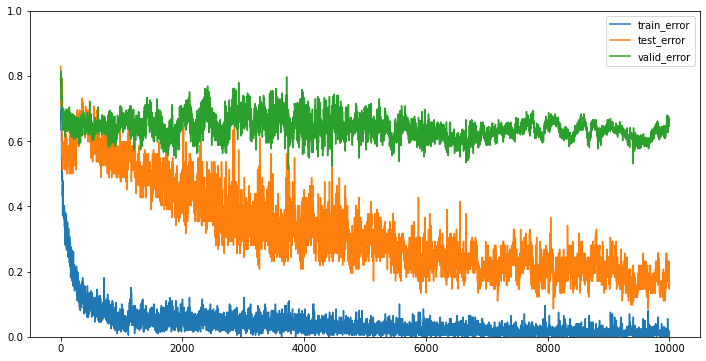

In [43]:
hist[['train_error','test_error','valid_error']].plot(figsize = (12, 6), ylim=(0,1))